In [14]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np
import torch
from typing import List, Optional
import torchvision
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [15]:
class Configs():
    def __init__(self):
        self.batch_size = 64
        self.lr = 1e-3
        self.epochs = 10
        self.print_every = 2
        self.seed = 42

configs = Configs()

In [16]:
class RadialBasisFunction(nnx.Module):
    def __init__(
            self,
            grid_min: float = -2.0,
            grid_max: float = 2.0,
            num_grids: int = 8,
            denominator : Optional[float] = None,
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        self.grid = nnx.Variable(jnp.linspace(grid_min, grid_max, num_grids))
        self.denominator = denominator if denominator else (grid_max - grid_min) / (num_grids -1)

    def __call__(self, x):
        return jnp.exp(-(((x[..., None] - self.grid) / self.denominator) ** 2))

In [17]:
class FastKANLayer(nnx.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        rngs: nnx.Rngs,
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_update_bias: bool = True,
        use_layernorm: bool = True,
        base_activation=nnx.silu,
        spline_weight_init_scale: float = 0.1,
        denominator: Optional[float] = None,
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.layernorm = None
        if use_layernorm:
            assert (
                input_dim > 1
            ), "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nnx.LayerNorm(input_dim, epsilon=1e-5, rngs=rngs)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids, denominator)
        coef_key = rngs.coef()
        self.coef = nnx.Param(
            jax.random.truncated_normal(
                coef_key,
                lower=-2.0,
                upper=-2.0,
                shape=(output_dim, input_dim, num_grids),
            )
            * jnp.array(spline_weight_init_scale)
        )
        self.use_base_update = use_base_update
        if self.use_base_update:
            self.base_linear = nnx.Linear(
                input_dim,
                output_dim,
                use_bias=base_update_bias,
                rngs=rngs,
            )
            self.base_activation = base_activation


    def __call__(self, x: jax.Array, use_layernorm: bool = True) -> jax.Array:
        """
        x: B, input_dim, num_grids
        """
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        out = jnp.einsum("bik, oik -> bo", spline_basis, self.coef.value)

        if self.use_base_update:
            res = self.base_linear(self.base_activation(x))
            out = res + out

        return out

In [18]:
class FastKAN(nnx.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        rngs: nnx.Rngs,
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        use_layernorm: bool = True,
        use_base_update: bool = True,
        base_update_bias: bool = True,
        base_activation=nnx.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        self.layers = [
            FastKANLayer(
                input_dim=in_dim,
                output_dim=out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_layernorm=use_layernorm,
                use_base_update=use_base_update,
                base_update_bias=base_update_bias,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
                rngs=rngs,
            )
            for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch]).numpy()
    labels = torch.tensor([item[1] for item in batch]).numpy()
    images = images.transpose(0, 2, 3, 1)    # nhwc
    return {"image": images, "label": labels}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(
    trainset,
    batch_size=configs.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    )  # num_workers 입력 주의: multiprocessing 충돌 발생

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = DataLoader(
    testset,
    batch_size=configs.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
class KANCNN(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(3, 32, kernel_size=(5, 5), rngs=rngs)
        self.pool = partial(nnx.max_pool, window_shape=(2,2), strides=(2,2))
        self.conv2 = nnx.Conv(32, 64, kernel_size=(5, 5), rngs=rngs)
        self.fc1 = FastKAN([8 * 8 * 64, 256], rngs=rngs)
        self.fc2 = FastKAN([256, 10], rngs=rngs)

    def __call__(self, x):
        x = self.pool(nnx.selu(self.conv1(x)))
        x = self.pool(nnx.selu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [21]:
model = KANCNN(rngs=nnx.Rngs(configs.seed))
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate=configs.lr))

In [22]:
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)

In [23]:
def loss_fn(model: nnx.Module, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    model.train()
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: nnx.Module, metrics: nnx.MultiMetric, batch):
    model.eval()
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])

In [24]:
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}
start_time = time()

for epoch in tqdm(range(configs.epochs)):
    for batch in train_loader:

       train_step(model, optimizer, metrics, batch)

    if epoch % configs.print_every == 0:
        # train log
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # test
        for test_batch in test_loader:
            eval_step(model, metrics, test_batch)

        # test log
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()

        print(
            f"epoch: {epoch}, "
            f"train_loss: {metrics_history['train_loss'][-1]:.4f}, "
            f"train_accuracy: {metrics_history['train_accuracy'][-1] * 100:.4f}, "
            f"test_loss: {metrics_history['test_loss'][-1]:.4f}, "
            f"test_accuracy: {metrics_history['test_accuracy'][-1] * 100:.4f} "
        )

end_time = time()
total_time = end_time - start_time
print(f'elapsed time: {total_time:.2f}sec')

 10%|█         | 1/10 [00:24<03:44, 24.95s/it]

epoch: 0, train_loss: 1.2834, train_accuracy: 52.9320, test_loss: 1.0595, test_accuracy: 61.7700 


 30%|███       | 3/10 [01:05<02:29, 21.41s/it]

epoch: 2, train_loss: 0.7525, train_accuracy: 73.1900, test_loss: 0.8460, test_accuracy: 70.5600 


 50%|█████     | 5/10 [01:45<01:43, 20.79s/it]

epoch: 4, train_loss: 0.3342, train_accuracy: 88.7060, test_loss: 0.8590, test_accuracy: 73.1600 


 70%|███████   | 7/10 [02:25<01:01, 20.51s/it]

epoch: 6, train_loss: 0.0827, train_accuracy: 97.8620, test_loss: 1.0153, test_accuracy: 72.5700 


 90%|█████████ | 9/10 [03:05<00:20, 20.45s/it]

epoch: 8, train_loss: 0.0698, train_accuracy: 97.9270, test_loss: 1.2407, test_accuracy: 70.6600 


100%|██████████| 10/10 [03:24<00:00, 20.42s/it]

elapsed time: 204.21sec


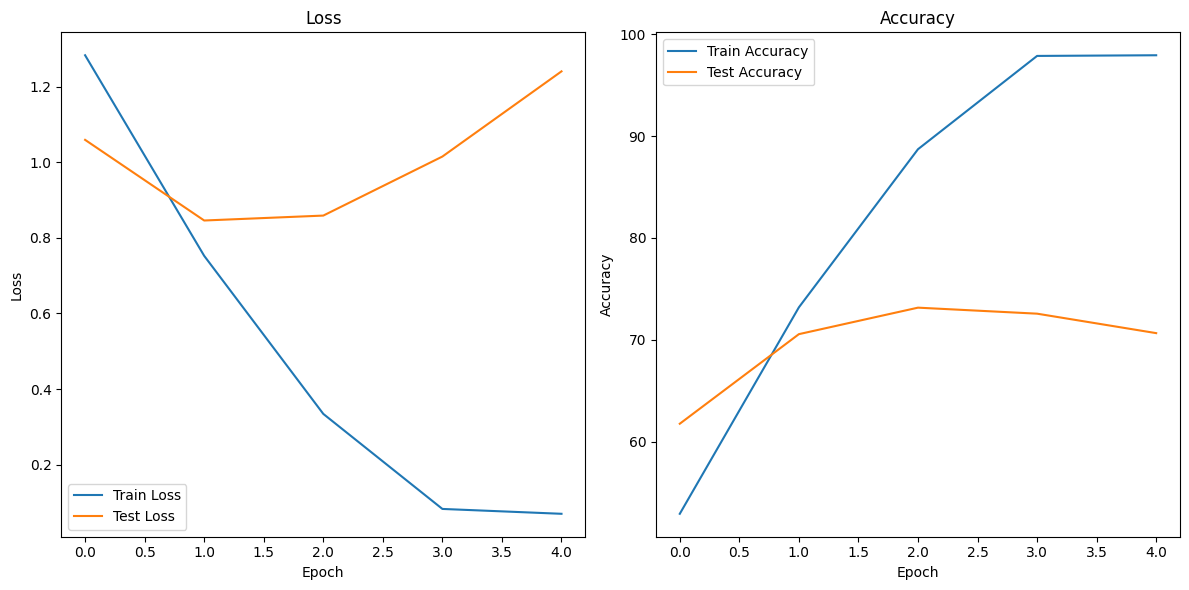

In [25]:
plt.figure(figsize=(12, 6))

# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(metrics_history["train_loss"], label="Train Loss")
plt.plot(metrics_history["test_loss"], label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([x * 100 for x in metrics_history["train_accuracy"]], label="Train Accuracy")
plt.plot([x * 100 for x in metrics_history["test_accuracy"]], label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


for batch in test_loader:
    images = batch['image']
    labels = batch['label']
    outputs = model(images)
    predictions = np.argmax(outputs, 1)

    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 79.1 %
Accuracy for class: car   is 85.8 %
Accuracy for class: bird  is 51.9 %
Accuracy for class: cat   is 39.1 %
Accuracy for class: deer  is 68.0 %
Accuracy for class: dog   is 73.6 %
Accuracy for class: frog  is 78.7 %
Accuracy for class: horse is 79.0 %
Accuracy for class: ship  is 89.8 %
Accuracy for class: truck is 69.5 %
